<a href="https://colab.research.google.com/github/am-bean/SummerDoctoralProgram/blob/main/RegressionExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
%matplotlib inline
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os.path as path

In [51]:
data_csv = 'regression_example.csv'
if not path.exists(data_csv):
    data_csv = 'https://raw.githubusercontent.com/am-bean/SummerDoctoralProgram/main/regression_example.csv'

df = pd.read_csv(data_csv,skiprows=1)

df = df.iloc[:-7,:]
df['%Women'] = df['%Women'].astype(float).copy()
df['%Internet'] = df['%Internet'].astype(float).copy()

In [52]:
df.head()

,Country,%Women,%Internet
0,Rwanda,61.3,30.5
1,Cuba,53.4,71.1
2,Nicaragua,51.7,57.1
3,Mexico,50.0,75.6
4,New Zealand,50.0,95.9


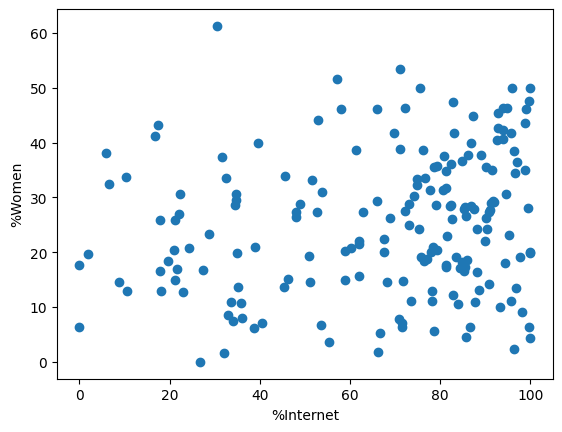

In [53]:
plt.figure()
plt.scatter('%Internet', '%Women', data=df)
plt.xlabel("%Internet")
plt.ylabel("%Women")
plt.show()

In [63]:
my_lm = sm.OLS(df['%Women'],df['%Internet']).fit()
print(my_lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                 %Women   R-squared (uncentered):                   0.736
Model:                            OLS   Adj. R-squared (uncentered):              0.735
Method:                 Least Squares   F-statistic:                              516.7
Date:                Wed, 05 Jul 2023   Prob (F-statistic):                    1.90e-55
Time:                        21:08:08   Log-Likelihood:                         -761.98
No. Observations:                 186   AIC:                                      1526.
Df Residuals:                     185   BIC:                                      1529.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [66]:
x = np.linspace(df['%Internet'].min(),df['%Internet'].max(),100)
y = x * my_lm.params['%Internet']

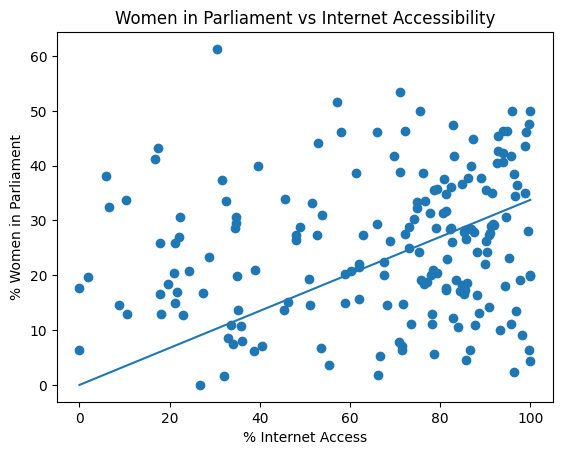

In [69]:
plt.figure()
plt.scatter('%Internet', '%Women', data=df)
plt.plot(x,y)
plt.xlabel("% Internet Access")
plt.ylabel("% Women in Parliament")
plt.title('Women in Parliament vs Internet Accessibility')
plt.show()